In [0]:
import tensorflow as tf
import keras
from keras.layers import LeakyReLU
from os import listdir
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from numpy import vstack
from numpy import ones
from numpy import zeros
from keras.initializers import RandomNormal
from numpy.random import randint

In [0]:
#Loading the dataset and spliting it into edge images and real images
def load_images(path, size=(256,512)):
  src_img, targ_img = list(), list()
  for filename in listdir(path):
    image = load_img(path+'/'+filename, target_size=size)
    pixels = img_to_array(image)
    edge_image, real_image = pixels[:,:256], pixels[:,256:]
    src_img.append(edge_image)
    targ_img.append(real_image)
  return [asarray(src_img), asarray(targ_img)]

path = "/facades/train"
print(path)
[src_imageset, targ_imageset] = load_images(path)
print("loaded:", src_imageset.shape, targ_imageset.shape)
filename = "facades.npz"
savez_compressed(filename, src_imageset, targ_imageset)
print("saved dataset", filename)


loaded: (400, 256, 256, 3) (400, 256, 256, 3)


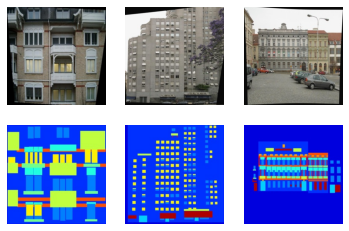

In [0]:
#display images
from numpy import load
from matplotlib import pyplot

data = load("facades.npz")
src_image, targ_image = data["arr_0"], data["arr_1"]
print("loaded:", src_image.shape, targ_image.shape)
n=3
for i in range(n):
  pyplot.subplot(2,n,1+i)
  pyplot.axis("off")
  pyplot.imshow(src_image[i].astype("uint8"))

for i in range(n):
  pyplot.subplot(2,n,1+n+i)
  pyplot.axis("off")
  pyplot.imshow(targ_image[i].astype("uint8"))

In [0]:
def discriminator(image_shape):
  init = RandomNormal(stddev=0.02)
  in_src_image = keras.layers.Input(shape=image_shape)
  in_target_image = keras.layers.Input(shape=image_shape)
  merged = keras.layers.Concatenate()([in_src_image, in_target_image])

  d = keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)
  d = keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = keras.layers.BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = keras.layers.BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = keras.layers.BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = keras.layers.Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
  d = keras.layers.BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = keras.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  patch_out = keras.layers.Activation('sigmoid')(d)
  model = keras.models.Model([in_src_image, in_target_image], patch_out)

  opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model

In [0]:
# Generator function
def encoder_block(input_tensor, n_filters, kernel_size = 4, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    # first layer
    x = keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), strides=(2,2), padding = 'same', kernel_initializer=init)(input_tensor)
    if batchnorm:
      x = keras.layers.BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    return x

def decoder_block(input_tensor, skip_layer, n_filters, dropout=True):
  init = RandomNormal(stddev=0.02)
  x = keras.layers.Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(input_tensor)
  x = keras.layers.BatchNormalization()(x, training=True)
  if dropout:
    x = keras.layers.Dropout(0.5)(x, training=True)
  x = keras.layers.Concatenate()([x, skip_layer])
  x = keras.layers.Activation("relu")(x)
  return x


def generator(input_img=(256,256,3), batchnorm=True, dropout=True):
    init = RandomNormal(stddev=0.02)
    image = keras.layers.Input(shape=input_img)
    # Contracting Path
    c1 = encoder_block(image, 64, kernel_size = 4, batchnorm=False)
    c2 = encoder_block(c1, 128, kernel_size = 4, batchnorm=batchnorm)
    c3 = encoder_block(c2, 256, kernel_size = 4, batchnorm=batchnorm) 
    c4 = encoder_block(c3, 512, kernel_size = 4, batchnorm=batchnorm)
    c5 = encoder_block(c4, 512, kernel_size = 4, batchnorm=batchnorm)
    c6 = encoder_block(c5, 512, kernel_size = 4, batchnorm=batchnorm)
    c7 = encoder_block(c6, 512, kernel_size = 4, batchnorm=batchnorm)
 
    m = keras.layers.Conv2D(512, (4,4), strides = (2,2), padding="same", kernel_initializer=init)(c7)
    m = keras.layers.Activation("relu")(m)
    
    # Expansive Path
    d1 = decoder_block(m, c7, 512, dropout=dropout)
    d2 = decoder_block(d1, c6, 512, dropout=dropout)
    d3 = decoder_block(d2, c5, 512, dropout=dropout)
    d4 = decoder_block(d3, c4, 512, dropout=False)
    d5 = decoder_block(d4, c3, 256, dropout=False)
    d6 = decoder_block(d5, c2, 128, dropout=False)
    d7 = decoder_block(d6, c1, 64, dropout=False)
  
    outputs = keras.layers.Conv2DTranspose(3, (4, 4), strides=(2,2), padding="same", kernel_initializer=init)(d7)
    outputs = keras.layers.Activation("tanh")(outputs)
    model = keras.models.Model(inputs=[image], outputs=[outputs])
    return model

In [0]:
# GAN model, combined discriminator and Generator
def gan_model(generator, discriminator, input_img):
  discriminator.trainable = False
  src_input = keras.layers.Input(shape = input_img)
  gen_output = generator(src_input)
  disc_output = discriminator([src_input, gen_output])
  model = keras.models.Model(inputs=src_input, outputs=[disc_output, gen_output])
  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss=["binary_crossentropy", "mae"], optimizer=opt, loss_weights=[1,100])
  return model

In [0]:
def load_dataset(filename):
  data = load(filename)
  X1, X2 = data["arr_0"], data["arr_1"]
  X1 = (X1 - 127.5)/127.5
  X2 = (X2 - 127.5)/127.5
  return [X1,X2]

In [0]:
def generate_real_images(dataset, n, patch_shape):
  trainA, trainB = dataset
  ix = randint(0, trainA.shape[0],n)
  X1, X2 = trainA[ix], trainB[ix]
  y = ones((n, patch_shape, patch_shape,1))
  return [X1,X2], y

In [0]:
def generate_fake_images(model, sample, patch_shape):
  print("number of shape")
  print(sample.shape)
  print("patch shape")
  print(patch_shape)
  X = model.predict(sample)
  print("fake image size")
  print(X.shape)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X,y

In [0]:
def performance_check(step, model, dataset, n=3):
  [realA, realB], _ = generate_real_images(dataset, n, 1)
  fakeB, _ = generate_fake_images(model, realA, 1)
  realA = (realA+1)/2.0
  realB = (realB+1)/2.0
  fakeB = (fakeB+1)/2.0

# plot real source images
  for i in range(n):
    pyplot.subplot(3, n, 1+i)
    pyplot.axis("off")
    pyplot.imshow(realA[i])
  
#plot generated target images  
  for i in range(n):
    pyplot.subplot(3, n, 1+n+i)
    pyplot.axis("off")
    pyplot.imshow(fakeB[i])

# plot real target images
  for i in range(n):
    pyplot.subplot(3, n, 1+n*2+i)
    pyplot.axis("off")
    pyplot.imshow(realB[i])
  filename1 = 'plot_%06d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()
  filename2 = 'model_%6d.h5' % (step+1)
  model.save(filename2)
  print(">saved: %s and %s" % (filename1, filename2))

In [0]:
def train_gan(disc_model, gen_model, gan_model, dataset, epochs=100, batch=1):
  n_patch = disc_model.output_shape[1]
  trainA, trainB = dataset
  batch_per_epoch = int(len(trainA)/batch)  #400
  print(batch_per_epoch)
  steps = batch_per_epoch*epochs   #40000
  print("steps")
  print(steps)
  
  for i in range(steps):
    print(i)
    [realA, realB], y_real = generate_real_images(dataset, batch, n_patch)
    fakeB, y_fake = generate_fake_images(gen_model, realA, n_patch)
    disc_loss1 = disc_model.train_on_batch([realA, realB], y_real)
    disc_loss2 = disc_model.train_on_batch([realA, fakeB], y_fake)
    gen_loss, _, _ = gan_model.train_on_batch(realA, [y_real, realB])
    print(">%d, d1[%.3f] d2[%.3f] g[%.3f]" %(i+1, disc_loss1, disc_loss2, gen_loss))  
    if (i+1) % (batch_per_epoch*10) == 0 :  
      performance_check(i, gen_model, dataset)

In [0]:
dataset = load_dataset('facades.npz')
print("Loaded", dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]
disc_model = discriminator(image_shape)
gen_model = generator(image_shape)
gan_model = gan_model(gen_model, disc_model, image_shape)
train_gan(disc_model, gen_model, gan_model, dataset)